In [14]:
##importing necessary libraries for computation and analysis
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

add_data = '/home/cccr/roxy/matin/MTech_project/data/'

In [26]:
dataset = xr.open_dataset( add_data + "sst40yearmean.nc")
ds = xr.open_dataset( add_data + "sst.day.mean.2021.nc")
ds_40=dataset.sel(time=~((dataset.time.dt.month == 2) & (dataset.time.dt.day == 29)))



In [ ]:
nintey_percentile = ds_40.groupby('time.dayofyear').quantile(0.9,dim='time',skipna=True)
avg_data = ds_40.groupby('time.dayofyear').mean(dim='time',skipna=True)

In [22]:
ds_40 = ds_40.sst.sel(lon=slice(84,93.625),lat=slice(15,21.125))

In [48]:
roi = ds_40.sst[-1825:-1460].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


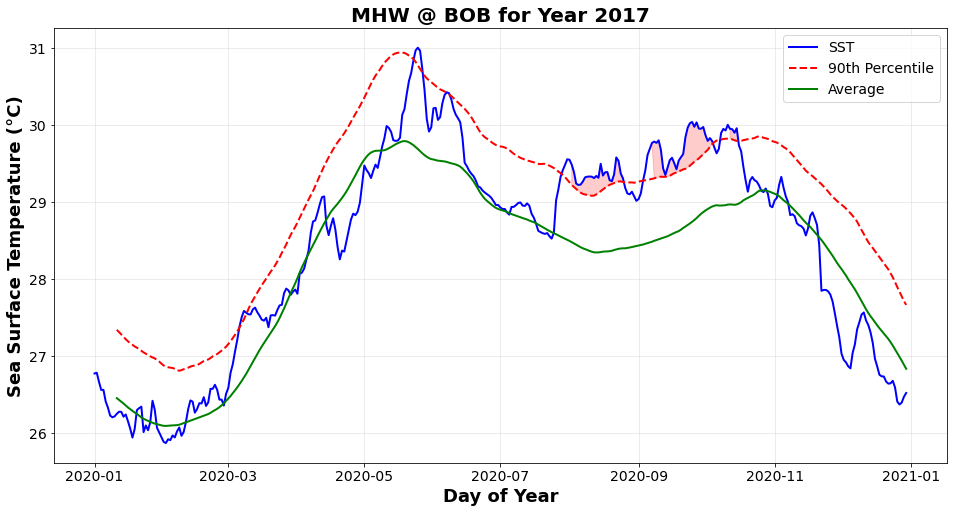

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2017", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



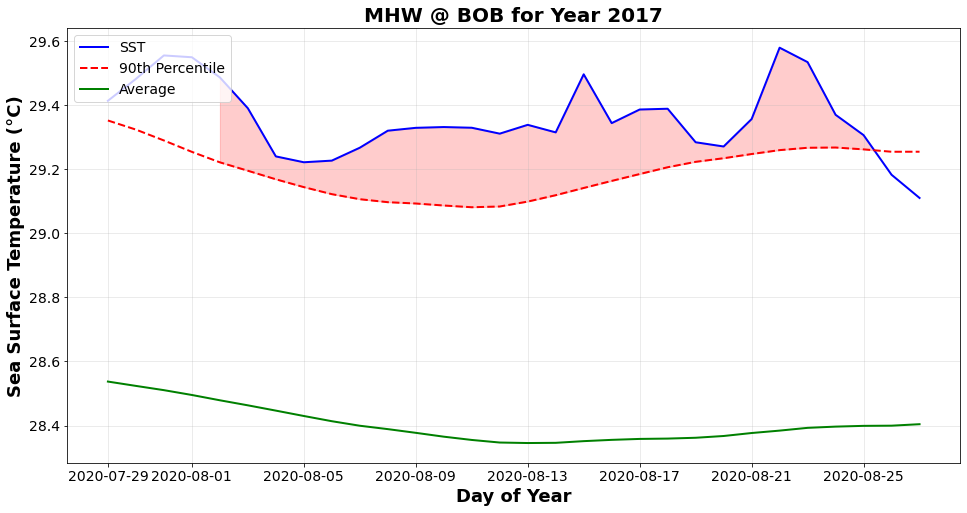

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'][210:240], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'][210:240], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'][210:240], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'][210:240] > DataFrame['90percentile'][210:240]).rolling(5).sum()>=5
ax.fill_between(DataFrame.index[210:240], DataFrame['SST'][210:240], DataFrame['90percentile'][210:240], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2017", fontsize=20, fontweight='bold')

ax.legend(loc="upper left", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
#fig.savefig('MHW2018.png', bbox_inches='tight')



In [68]:

rf = xr.open_dataarray(add_data + "rfbobmm_daily_1998-2019.nc")[:-30]
rf = rf.interpolate_na(dim="time")
sst = xr.open_dataarray(add_data + "tmpC_sstbob_1998-2020.nc")[:-731]

n_rainfall = xr.open_dataset(add_data + 'n_rf.nc')
n_sst = xr.open_dataset(add_data + 'n_sst.nc')

rainfall = xr.open_dataset(add_data + 'filteredrf.nc')
filtered_sst = xr.open_dataset(add_data + 'filteredsst.nc')

In [69]:
sst_mon = sst.isel(time=sst.time.dt.month.isin([ 8, 9]))
rf_mon = rf.isel(time=rf.time.dt.month.isin([ 8, 9]))
Fsst_mon = filtered_sst.isel(time=filtered_sst.time.dt.month.isin([8, 9]))
Frf_mon = rainfall.isel(time=rainfall.time.dt.month.isin([8, 9]))

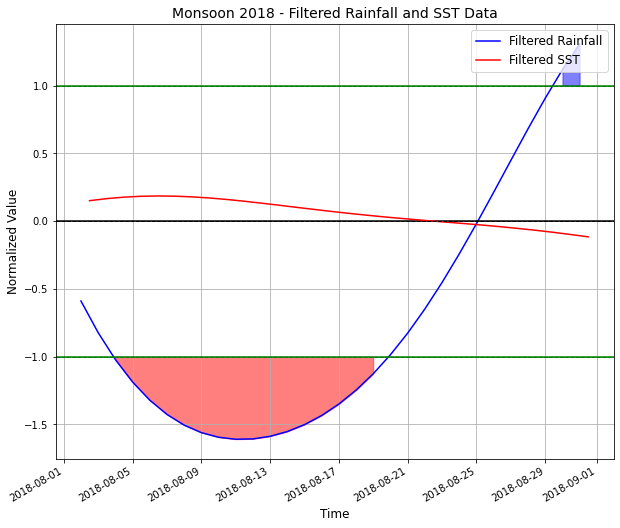

In [84]:
plt.figure(figsize=[10,8])

# Plot filtered rainfall data
rainfall_mean = Frf_mon.mean(dim = ['lon', 'lat']).__xarray_dataarray_variable__.rename('Frf')[-60:-30]
filtered_rf = xr.DataArray(rainfall_mean, coords={"time":rainfall_mean.time},dims=["time"])
x = filtered_rf.time.data
y = filtered_rf.data
filtered_rf.plot(color = 'b', label='Filtered Rainfall')
#sns.lineplot(x=x, y=y, color='b')
plt.axhline(y=0, color='black')
plt.axhline(y=1, color='g')
plt.axhline(y=-1, color='g')
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color='blue', alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color='red', alpha=0.5)


# Plot filtered SST data
sst_mean = Fsst_mon.mean(dim = ['lon', 'lat']).analysed_sst[-60:-30]
filtered_sst = xr.DataArray(sst_mean, coords={"time":sst_mean.time},dims=["time"])
x = filtered_sst.time.data
y = filtered_sst.data
filtered_sst.plot(color = 'r', label='Filtered SST')

# Add horizontal lines and fill color between them
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axhline(y=1, color='g', linestyle='--', linewidth=1)
plt.axhline(y=-1, color='g', linestyle='--', linewidth=1)
above_threshold = y > 1
below_threshold = y < -1
plt.fill_between(x, y, 1, where=above_threshold, color='red', alpha=0.5)
plt.fill_between(x, y, -1, where=below_threshold, color='blue', alpha=0.5)

# Set axis labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title("Monsoon 2018 - Filtered Rainfall and SST Data", fontsize=14)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add gridlines
plt.grid(True)

# Save figure
#plt.savefig("CombinedSSTRF.png")


In [79]:
Fsst_mon.mean(dim = ['lon', 'lat'])

<xarray.Dataset>
Dimensions:       (time: 1281)
Coordinates:
  * time          (time) datetime64[ns] 1998-08-01T12:00:00 ... 2018-09-30T12...
Data variables:
    analysed_sst  (time) float32 0.09155 0.02642 -0.03729 ... 0.4127 0.4176

In [66]:


model = tf.keras.models.load_model(model_path)
pred = model.predict(x)
actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
corr

2023-03-03 15:47:18.953806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 15:47:26.470881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/apps/cdo_utility/1.9.3/cdo-1.9.3/src/lib:/home/apps/cdo_utility/1.9.3/cdo-1.9.3/libcdi:/home/apps/nco/5.1.2/intel/17.0.5/lib:/home/apps/cdo-2.0.5/cdo_nc4/2.0.5/lib:/opt/cray/job/2.2.2-6.0.4.0_8.2__g3c644b5.ari/lib64:/opt/intel/compilers_and_libraries_2016.3.210/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2016.3.210/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_

1/1 [==============================] - 3s 3s/step


array([[1.        , 0.82796074],
       [0.82796074, 1.        ]])

In [67]:
model_path = "/home/cccr/roxy/matin/MTech_project/model/model/AConvLSTM/7in1out/7in_1outsstrf.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)
actual = y.flatten()
prediction = pred.flatten()
corr = np.corrcoef(actual,prediction)
corr

1/1 [==============================] - 1s 879ms/step


array([[1.        , 0.84426975],
       [0.84426975, 1.        ]])

In [25]:
ds_40[-1460:-1095]

<xarray.DataArray 'sst' (time: 365, lat: 25, lon: 39)>
[355875 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * lat      (lat) float32 15.12 15.38 15.62 15.88 ... 20.38 20.62 20.88 21.12
  * lon      (lon) float32 84.12 84.38 84.62 84.88 ... 92.88 93.12 93.38 93.62
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

In [46]:
roi = ds_40.sst[-2555:-2190].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


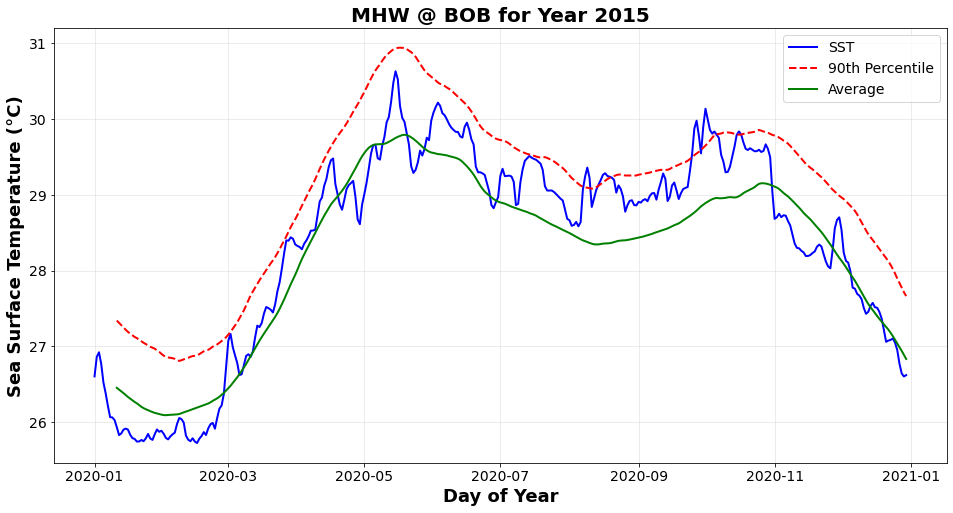

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2015", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



In [44]:
roi = ds_40.sst[-2190:-1825].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


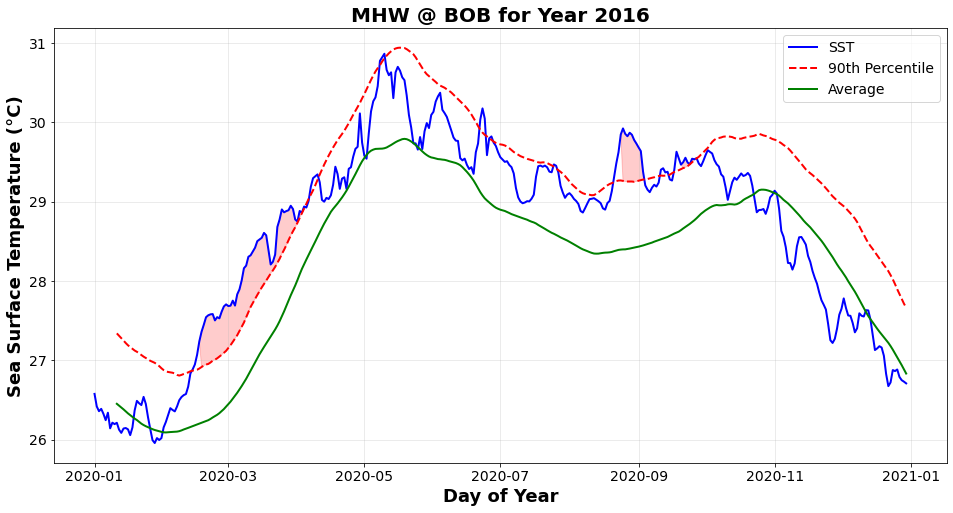

In [45]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2016", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



In [27]:
roi = ds_40.sst[-1460:-1095].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


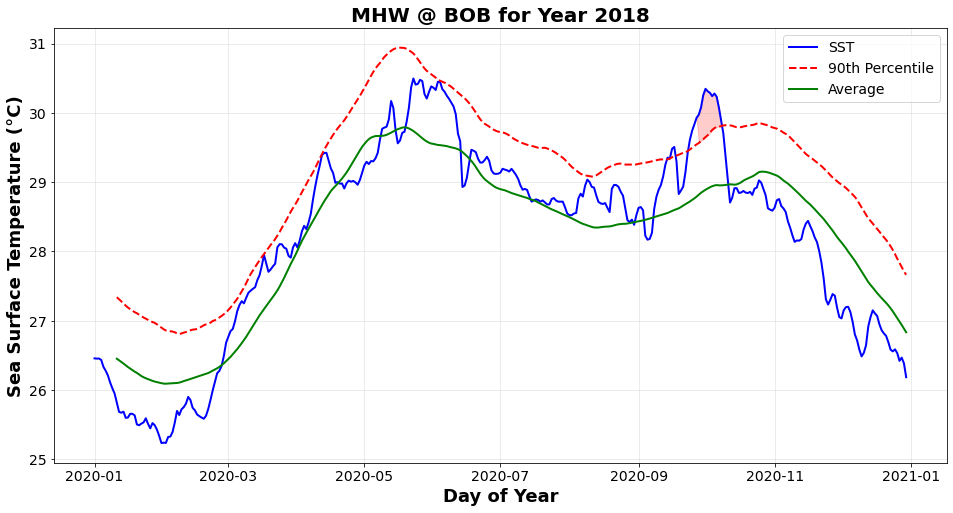

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2018", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



In [30]:
roi = ds_40.sst[-1095:-730].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


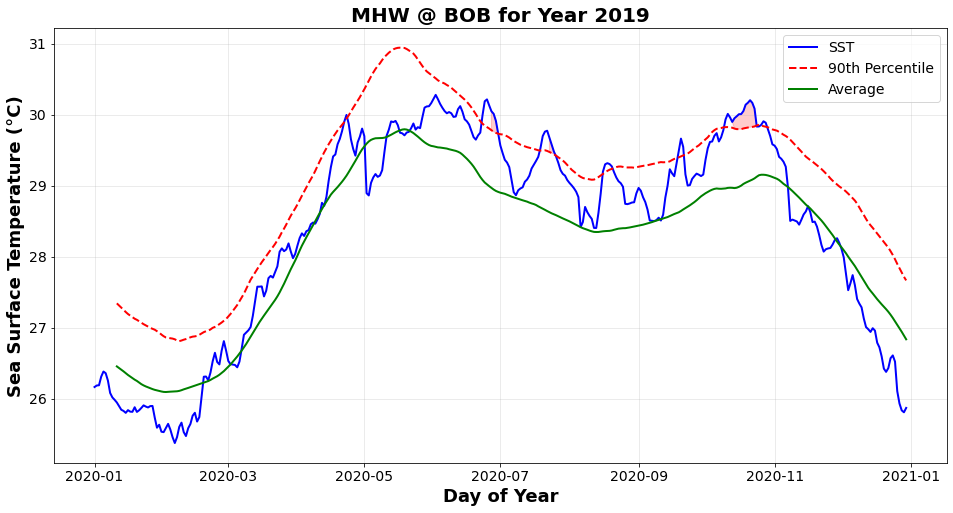

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2019", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



In [32]:
roi = ds_40.sst[-730:-365].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


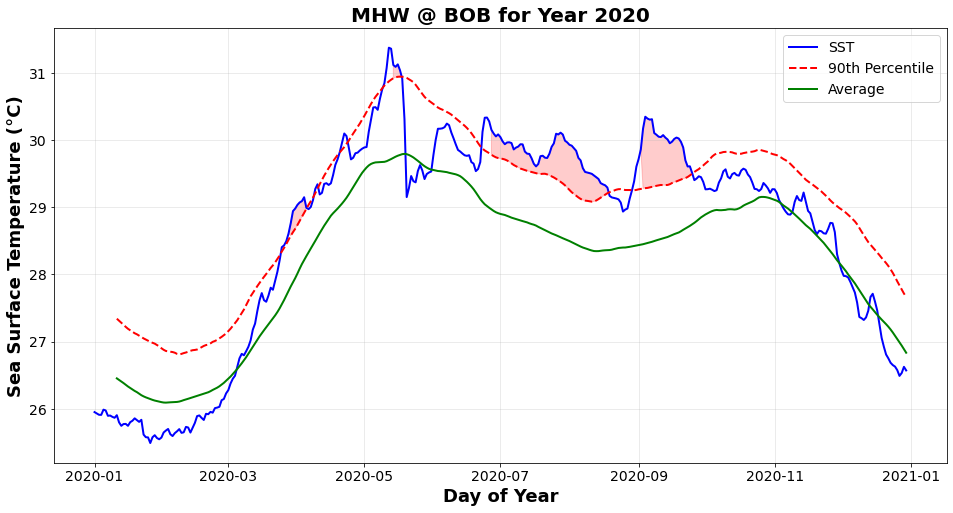

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2020", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')



In [34]:
roi = ds_40.sst[-365:].sel(lon=slice(84,93.625),lat=slice(15,21.125))
sst_mean_roi = roi.astype(np.float32).mean(dim=['lat','lon']).data

rolling_mean = nintey_percentile.rename({'dayofyear':'time'}).rolling(time=11).mean()
rolling_avg = avg_data.rename({'dayofyear':'time'}).rolling(time=11).mean()
NinteyPercentile_spatmean = rolling_mean.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
Average_spatmean = rolling_avg.sst.sel(lon=slice(89,94),lat=slice(14,19)).astype(np.float32).mean(dim=['lat','lon']).data[:-1]
time = pd.date_range("2020-01-01", periods=365)


SST_mean_roi = pd.DataFrame(sst_mean_roi, index = time, columns=['SST'])
NinteyPercentile_spatmean = pd.DataFrame( NinteyPercentile_spatmean, index = time, columns=['90percentile'])
Average_spatmean = pd.DataFrame( Average_spatmean, index = time, columns=['Avg40'])

DataFrame = pd.concat([SST_mean_roi, NinteyPercentile_spatmean, Average_spatmean],axis=1)


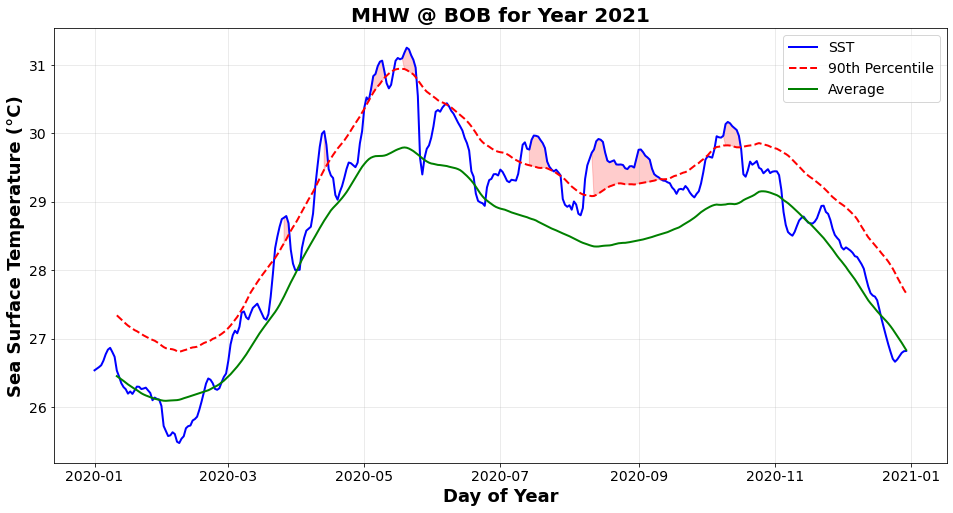

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(DataFrame['SST'], color='blue', linewidth=2, label='SST')

ax.plot(DataFrame['90percentile'], color='red', linestyle='--', linewidth=2, label='90th Percentile')

ax.plot(DataFrame['Avg40'], color='green', linewidth=2, label='Average')

mask = (DataFrame['SST'] > DataFrame['90percentile']).rolling(5).sum()>=5
ax.fill_between(DataFrame.index, DataFrame['SST'], DataFrame['90percentile'], where=mask, interpolate=True, color='red', alpha=0.2)

ax.set_xlabel("Day of Year", fontsize=18, fontweight='bold')
ax.set_ylabel("Sea Surface Temperature (°C)", fontsize=18, fontweight='bold')

ax.set_title("MHW @ BOB for Year 2021", fontsize=20, fontweight='bold')

ax.legend(loc="upper right", fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.grid(alpha=0.3)

plt.show()
fig.savefig('MHW2018.png', bbox_inches='tight')

